# Loading the Train, Test, and Validation Datasets
First, we'll load your datasets using PyTorch's DataLoader. This allows for efficient loading and preprocessing of the data.
This code defines the transformations for the images, including resizing, converting to tensor, and normalization. It then loads the datasets from specified folders and creates DataLoaders for each dataset. These DataLoaders will be used for training and evaluating the model.

In [4]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3090
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [5]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Set the paths for the datasets
base_folder = "../datasets/Vision_data"
train_folder = os.path.join(base_folder, "train")
test_folder = os.path.join(base_folder, "test")
validation_folder = os.path.join(base_folder, "validation")

# Create datasets
train_dataset = ImageFolder(root=train_folder, transform=transform)
test_dataset = ImageFolder(root=test_folder, transform=transform)
validation_dataset = ImageFolder(root=validation_folder, transform=transform)

batch_size = 256
num_workers = 4
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)


# Visualizing a Subset of the Training Images
Next, we'll randomly select 12 images from the training set and display them in a 3x4 grid. The images will be saved to the specified output folder. This code extracts 12 images from the training DataLoader and uses `matplotlib` to plot them. The imshow function handles the un-normalization and display of the images.

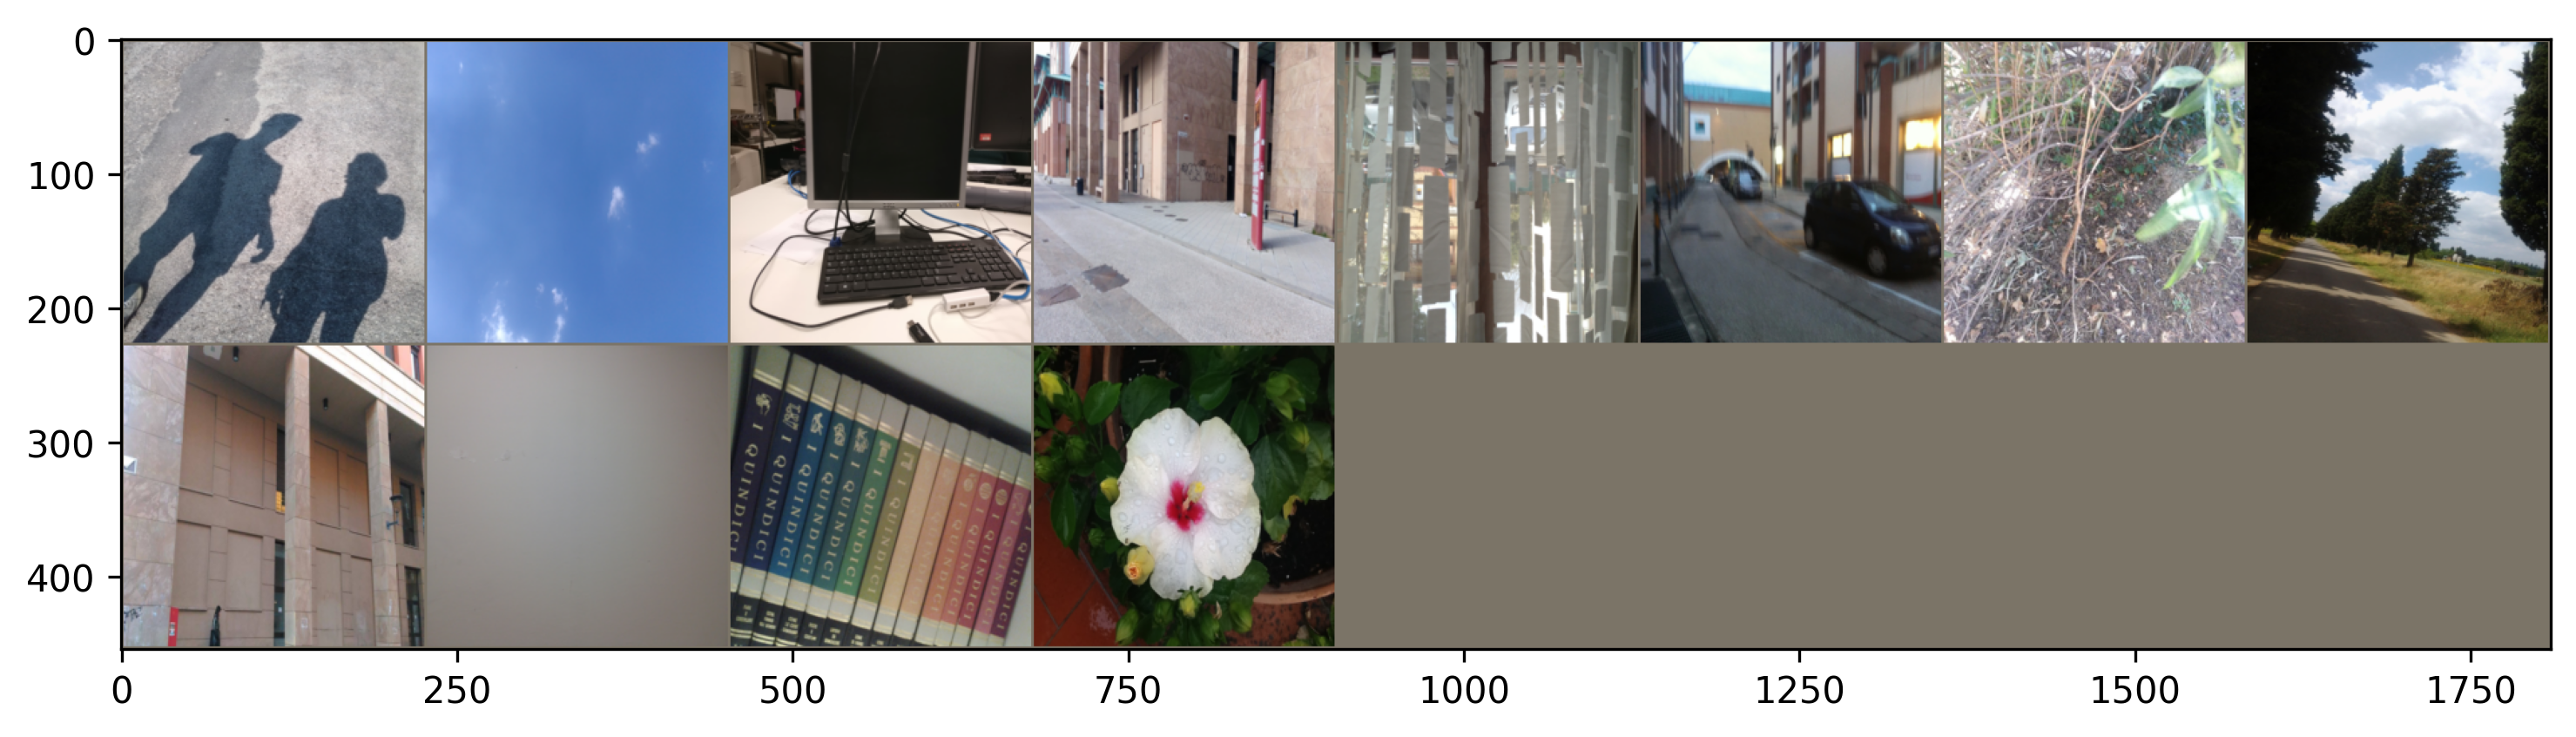

35


In [6]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import random

output_folder = "../output/resnet34"

def imshow(inp, title=None):
    """Imshow for Tensor."""
    plt.figure(figsize=(12, 7.5), dpi=300)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.savefig(os.path.join(output_folder, "ResNet34_train_images.jpg"), dpi=300, bbox_inches='tight')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:12])

imshow(out)

# Save the image
os.makedirs(output_folder, exist_ok=True)
print(len(train_dataset.classes))

# Training a ResNet-34 Model
Finally, we'll train a ResNet-34 model using the loaded datasets. This code assumes a GPU is available for training. This code sets up a pretrained ResNet-34 model, adapting its final layer to the number of classes in your dataset. It uses a GPU for training if available. The training loop includes backpropagation and optimization steps, and a learning rate scheduler is used to adjust the learning rate over time. The trained model is saved to the specified output folder.

## Basic Run


## TensorBoard Run with analytics

Epoch 1/20: 100%|██████████| 94/94 [07:31<00:00,  4.80s/it] 
C:\Users\nakulpadalkar\AppData\Local\Temp\ipykernel_10796\2960761671.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
Epoch 20/20: 100%|██████████| 94/94 [03:36<00:00,  2.30s/it]


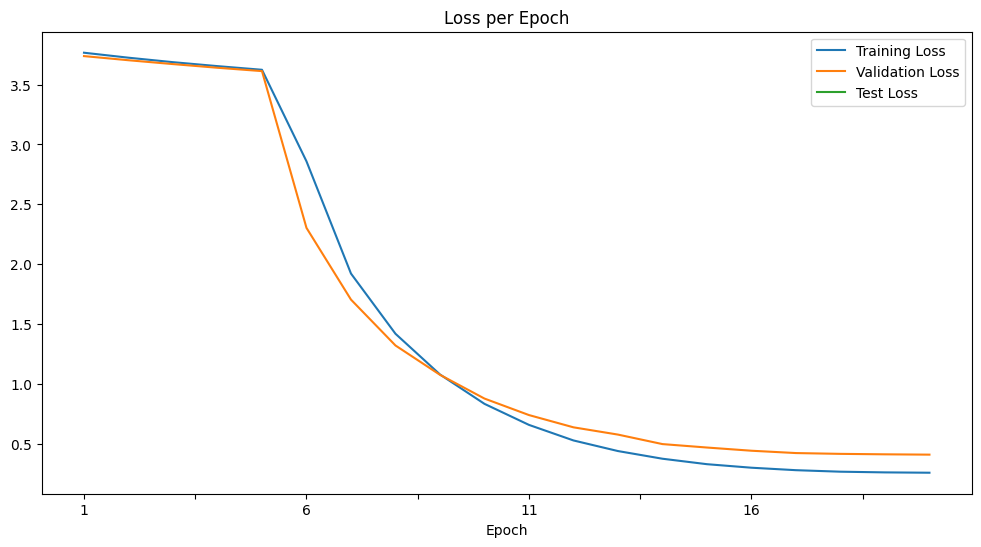

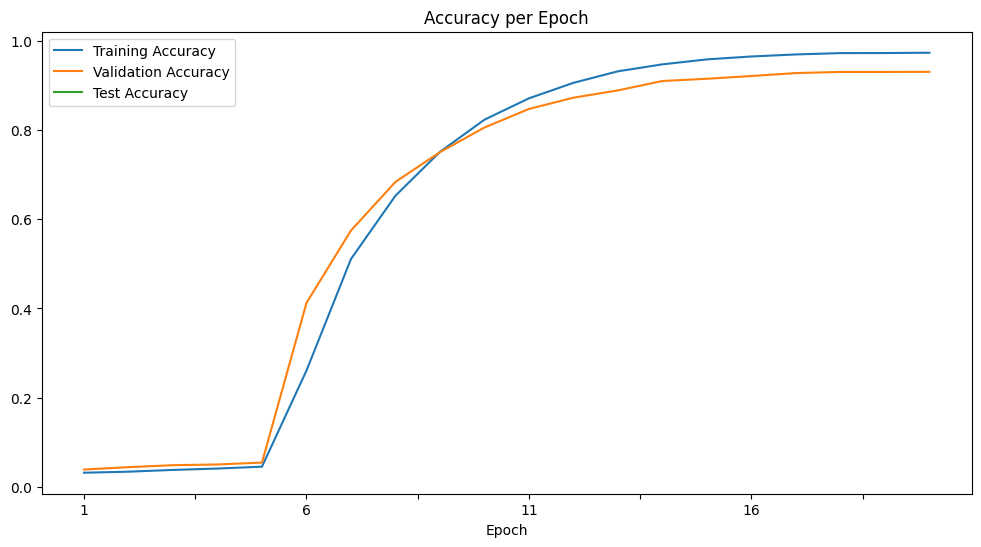

In [7]:
import os
import time
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and modify the pretrained ResNet model (ResNet34)
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
num_classes = len(train_dataset.classes)  # Ensure train_dataset is defined
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def warmup_cosine_annealing(lr, warmup_epochs, total_epochs, warmup_start_lr=1e-5):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return (lr - warmup_start_lr) / warmup_epochs * epoch + warmup_start_lr / lr
        elif total_epochs > warmup_epochs:
            return 0.5 * (1 + torch.cos(torch.tensor(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs))))
        else:
            return 1
    return lr_lambda

num_epochs = 20  # Make sure this is set correctly and is greater than warmup_epochs
scheduler = LambdaLR(optimizer, lr_lambda=warmup_cosine_annealing(0.001, 5, num_epochs))

# TensorBoard setup
writer = SummaryWriter('runs/resnet34_experiment')

# Initialize a DataFrame to store metrics
df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy', 'Epoch Duration'])
# df = pd.DataFrame(columns=['Epoch', 'Training Loss', 'Validation Loss', 'Test Loss', 'Training Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Epoch Duration'])
# df = df.astype({'Epoch': 'int32', 'Training Loss': 'float64', 'Validation Accuracy': 'float64', 'Test Accuracy': 'float64', 'Epoch Duration': 'float64'})


# Initialize best validation accuracy
best_val_accuracy = 0

# Training loop with model checkpointing and TensorBoard logging
for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training Phase
    model.train()
    total_train_loss = 0.0
    total_train = 0
    correct_train = 0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    writer.add_scalar('Loss/train', avg_train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)

    # Validation Phase
    model.eval()
    total_val_loss = 0.0
    total_val = 0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    val_accuracy = correct_val / total_val
    avg_val_loss = total_val_loss / len(validation_loader)
    writer.add_scalar('Loss/val', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/val', val_accuracy, epoch)

    epoch_duration = time.time() - start_time

    # Add data to DataFrame
    new_row = {
        'Epoch': epoch + 1,
        'Training Loss': avg_train_loss,
        'Validation Loss': avg_val_loss,
        'Training Accuracy': train_accuracy,
        'Validation Accuracy': val_accuracy,
        'Epoch Duration': epoch_duration
    }
    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Checkpointing
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), os.path.join(output_folder, f'resnet34_epoch{epoch}.pth'))

    scheduler.step()

# Test Phase
model.eval()
total_test_loss = 0.0
total_test = 0
correct_test = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
test_accuracy = correct_test / total_test
avg_test_loss = total_test_loss / len(test_loader)

# Record the test metrics
df.loc[df.index[-1], 'Test Loss'] = avg_test_loss
df.loc[df.index[-1], 'Test Accuracy'] = test_accuracy

# Save the DataFrame to a CSV file
output_folder = "../output/resnet34/"  # Make sure this folder exists
os.makedirs(output_folder, exist_ok=True)
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"ResNet34_training_results_{timestamp}.csv"
df.to_csv(os.path.join(output_folder, csv_filename), index=False)

writer.close()

# Plotting
df.set_index('Epoch', inplace=True)
df[['Training Loss', 'Validation Loss', 'Test Loss']].plot(figsize=(12, 6), title='Loss per Epoch')
plt.savefig(os.path.join(output_folder, 'loss_plot.png'))

df[['Training Accuracy', 'Validation Accuracy', 'Test Accuracy']].plot(figsize=(12, 6), title='Accuracy per Epoch')
plt.savefig(os.path.join(output_folder, 'accuracy_plot.png'))

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def get_all_predictions(loader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.view(-1).tolist())
            all_labels.extend(labels.view(-1).tolist())
    return all_preds, all_labels

# Get predictions and true labels for both datasets
train_preds, train_labels = get_all_predictions(train_loader, model, device)
val_preds, val_labels = get_all_predictions(validation_loader, model, device)

# Compute confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

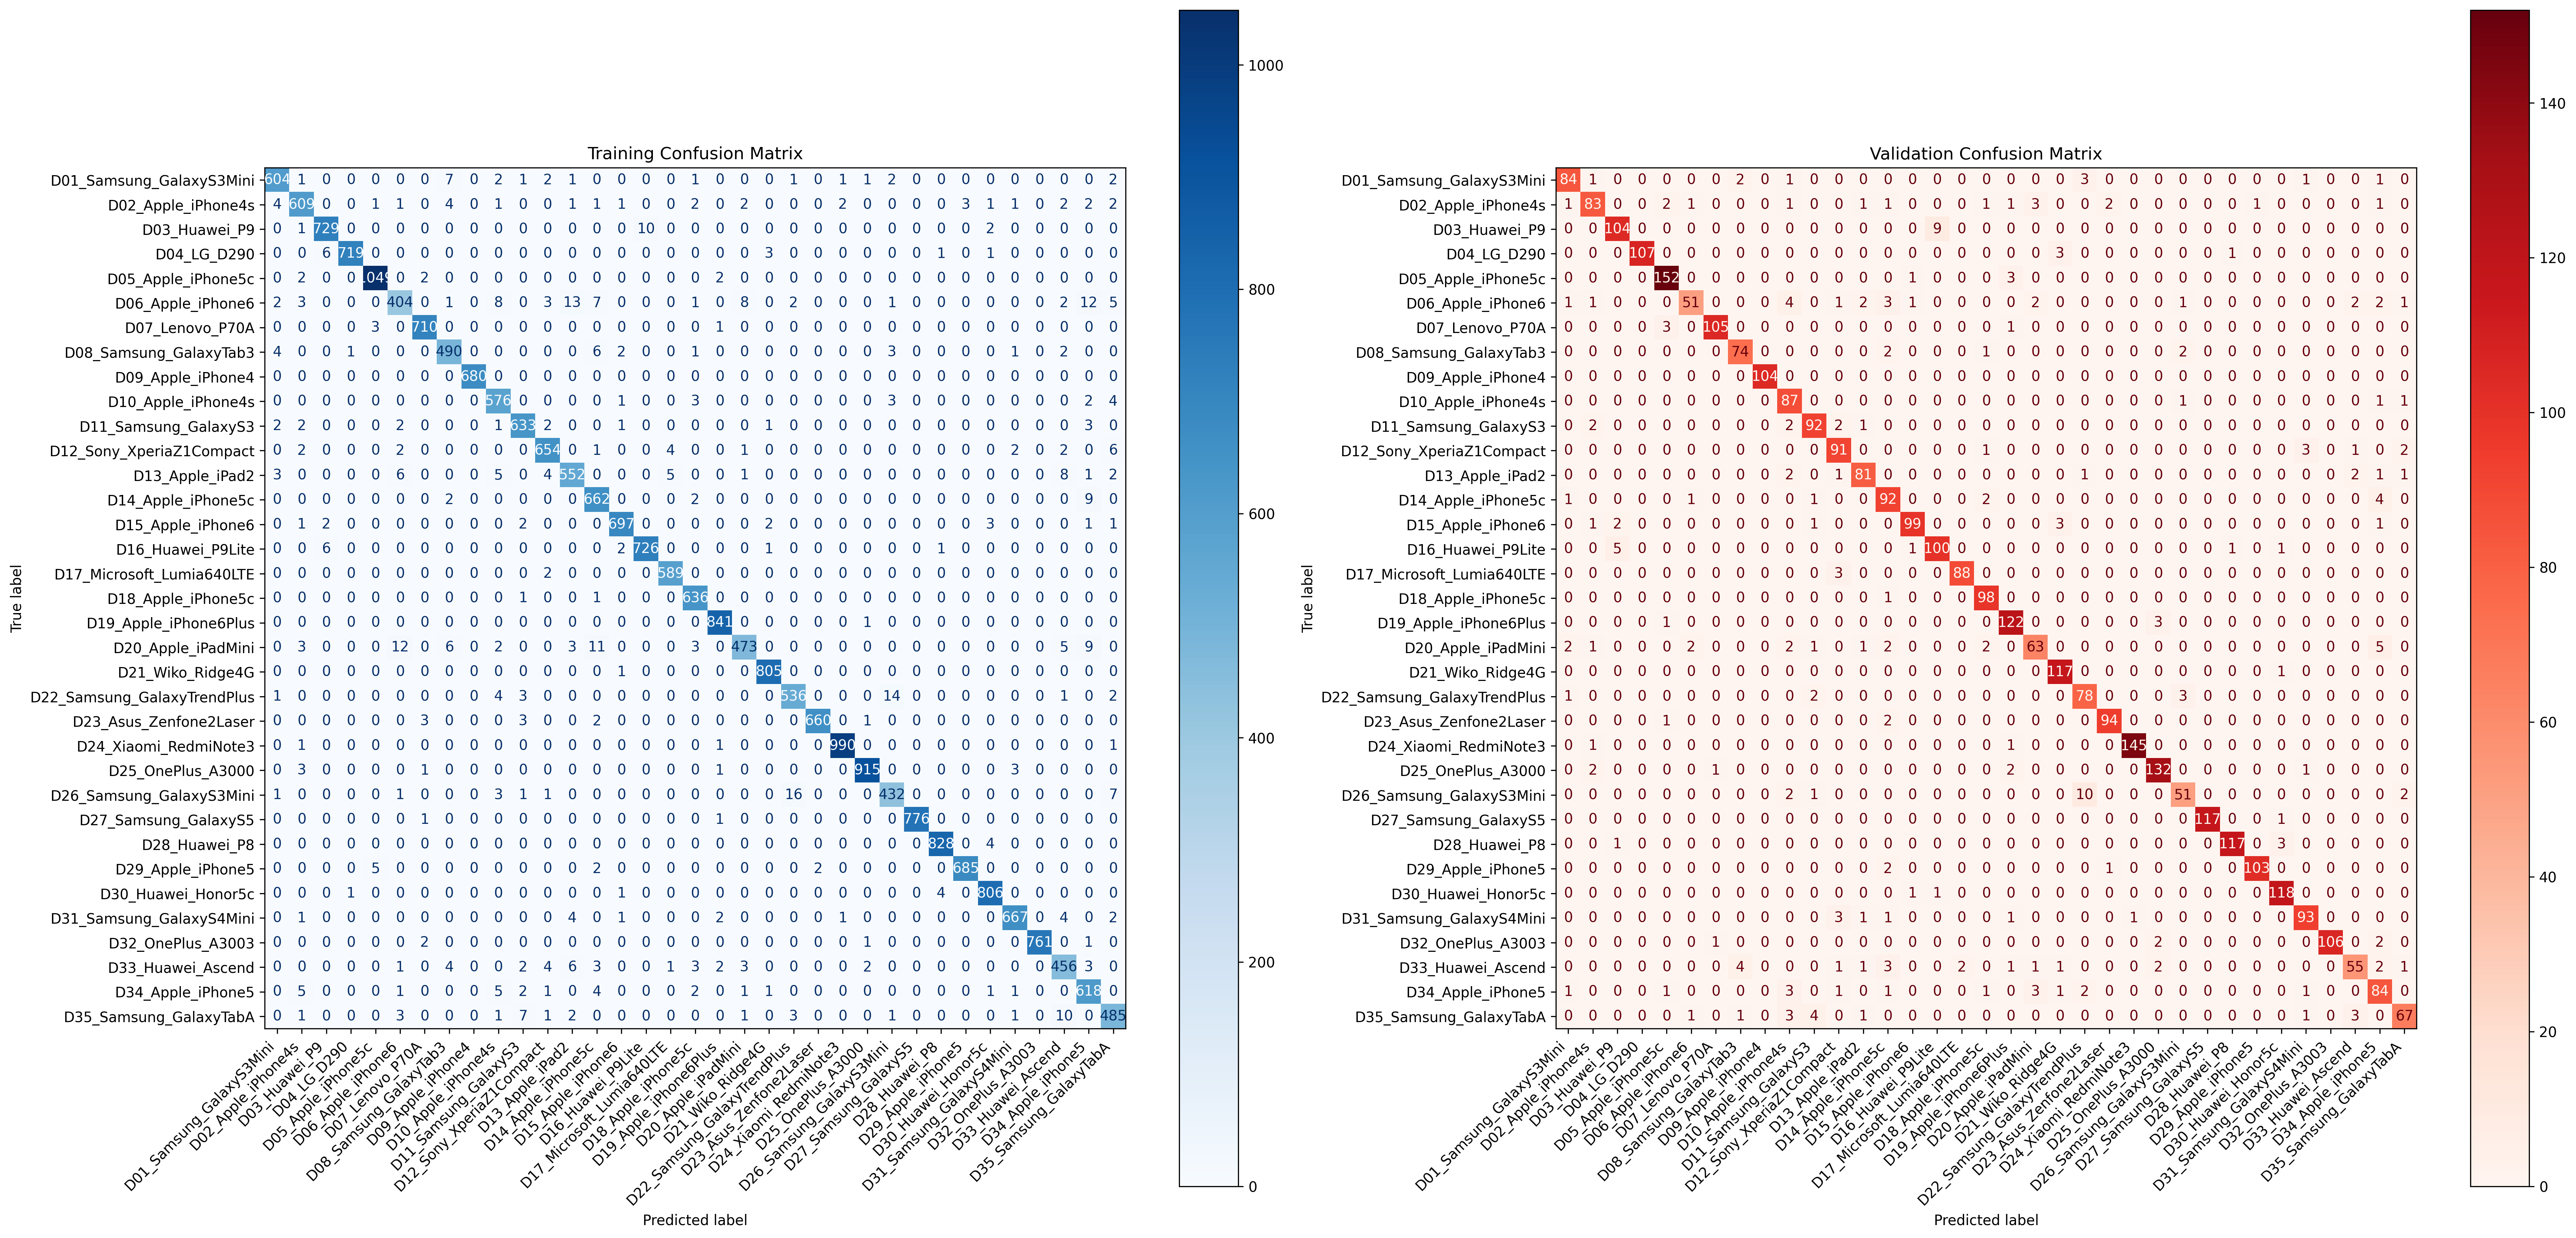

In [9]:
# Plot confusion matrices
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(30, 15), dpi=300)

ConfusionMatrixDisplay(train_cm, display_labels=train_dataset.classes).plot(ax=axes[0], cmap=plt.cm.Blues)
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xticklabels(rotation=45, labels=train_dataset.classes, ha= 'right')

ConfusionMatrixDisplay(val_cm, display_labels=validation_dataset.classes).plot(ax=axes[1], cmap=plt.cm.Reds)
axes[1].set_title('Validation Confusion Matrix')
axes[1].set_xticklabels(rotation=45, labels=validation_dataset.classes, ha='right')

plt.show()

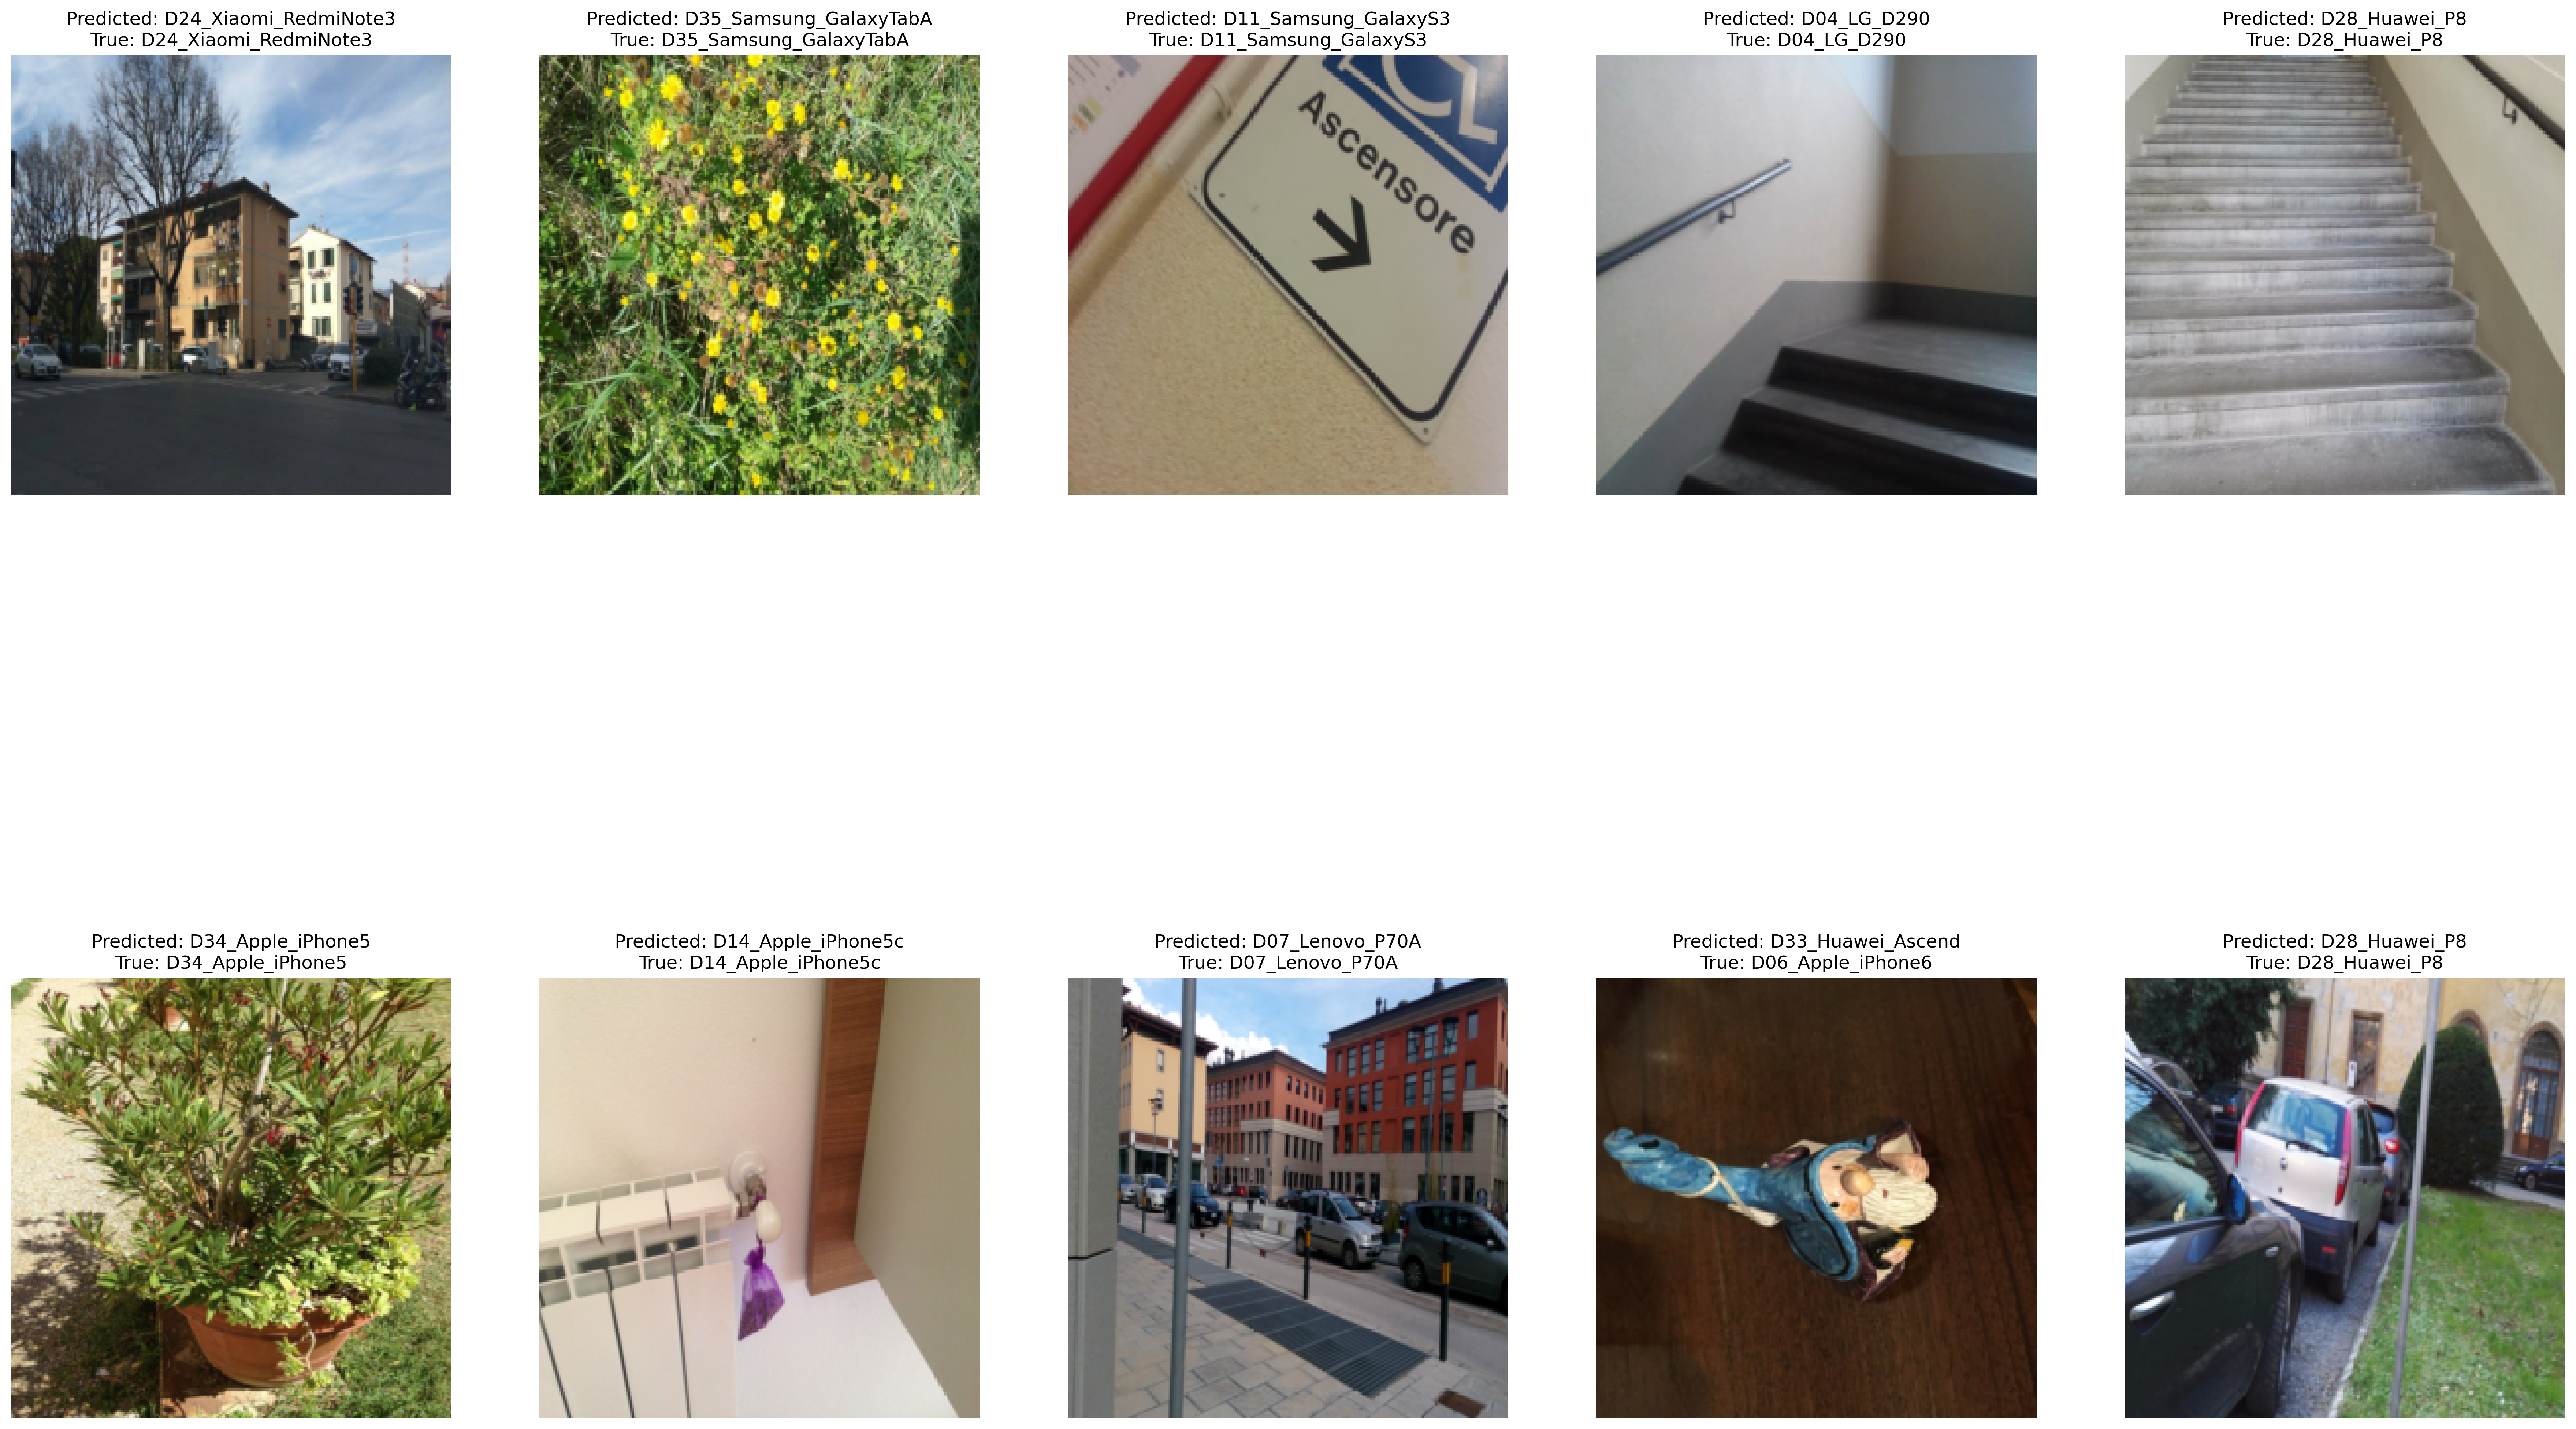

<Figure size 640x480 with 0 Axes>

In [10]:
import torch
import random
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Randomly select 10 images from the validation set
random_indices = random.sample(range(len(validation_dataset)), 10)
images, true_labels = zip(*[validation_dataset[i] for i in random_indices])

# Function to unnormalize and convert a tensor to a PIL image
def unnormalize_and_convert_to_pil(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(tensor.device)
    tensor = tensor.clone().detach()  # Clone the tensor
    tensor = tensor.mul_(std).add_(mean)  # Unnormalize
    tensor = tensor.clamp(0, 1)  # Clamp to the range [0, 1]
    return to_pil_image(tensor)

# Predict and display
plt.figure(figsize=(30, 20), dpi=300)
for i, (image, true_label) in enumerate(zip(images, true_labels)):
    # Predict
    image_tensor = image.unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_label = validation_dataset.classes[predicted[0]]

    # Convert image for display
    image_pil = unnormalize_and_convert_to_pil(image)

    # Display
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_pil)
    plt.title(f'Predicted: {predicted_label}\nTrue: {validation_dataset.classes[true_label]}')
    plt.axis('off')
plt.show()
plt.savefig('../output/resnet34/sample_predictions_ResNet34.jpg', dpi=300, bbox_inches='tight', pad_inches=0)